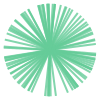

In [24]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import shapely.geometry as geo

import sys
sys.path.append("../")

from electronfactors.ellipse.sectorintegration import make_rays
from electronfactors.ellipse.utilities import shapely_cutout, shapely_point

x = np.array([-3, -2.5, -2, 3, 3, -3, -4, -3])
y = np.array([3, -2, 3, 3, -3, -3, 3, -2])

circle_diameter = np.array([3, 4, 5, 6, 7, 8, 9])
circle_factors = np.array(
    [0.9296, 0.9562, 0.9705, 0.9858, 1.0032, 1.0067, 1.0084])


def circle_fit(radii):

    circle_radii = circle_diameter/2

    spline = UnivariateSpline(circle_radii, circle_factors)
    results = spline(radii)

    results[radii > np.max(circle_radii)] = np.max(circle_factors)
    results[radii < np.min(circle_radii)] = 0

    return results


cutout = shapely_cutout(x, y)
point_of_interest = shapely_point(*[1, 0])

rays = make_rays(point_of_interest, cutout, 100)
rays

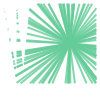

In [25]:
intersection = cutout.intersection(rays)
intersection

In [26]:
line_ends = [
    geo.MultiPoint(intersection[i].coords) for i in range(len(intersection))
]

distances = [[
        line_ends[j][i].distance(point_of_interest) for i in range(2)
    ] for j in range(len(intersection))]

begin_at_POI = np.array([distances[i][0] == 0.0 for i in range(len(distances))])

In [27]:
begin_at_POI

array([ True,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,

In [53]:
segment_groups_indices  = []
full_lines_index = np.arange(len(begin_at_POI)).astype('float')

for i in range(1, len(begin_at_POI)):

    if (~begin_at_POI[i]) & (begin_at_POI[i-1]):
        j = int(i)
        new_segment = [j - 1]
        full_lines_index[j - 1] = np.nan

        while ~(begin_at_POI[j]):
            new_segment.append(j)
            full_lines_index[j] = np.nan
            j += 1
            if j == len(begin_at_POI):
                break

        segment_groups_indices.append(new_segment)
        
segment_groups_indices

[[2, 3, 4],
 [8, 9, 10],
 [12, 13, 14],
 [15, 16, 17],
 [26, 27, 28],
 [31, 32, 33],
 [41, 42],
 [58, 59, 60],
 [63, 64, 65],
 [68, 69, 70],
 [81, 82, 83],
 [90, 91, 92],
 [104, 105, 106],
 [108, 109, 110],
 [114, 115, 116],
 [124, 125, 126],
 [130, 131, 132]]

In [54]:
full_lines_index

array([   0.,    1.,   nan,   nan,   nan,    5.,    6.,    7.,   nan,
         nan,   nan,   11.,   nan,   nan,   nan,   nan,   nan,   nan,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   nan,
         nan,   nan,   29.,   30.,   nan,   nan,   nan,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   nan,   nan,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   nan,   nan,   nan,   61.,   62.,
         nan,   nan,   nan,   66.,   67.,   nan,   nan,   nan,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         nan,   nan,   nan,   84.,   85.,   86.,   87.,   88.,   89.,
         nan,   nan,   nan,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,   nan,   nan,   nan,  107.,
         nan,   nan,   nan,  111.,  112.,  113.,   nan,   nan,   nan,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,   nan,   nan,
         nan,  127.,

In [48]:
for j in range(len(segment_groups)):
    x = [intersection[i].xy[0] for i in segment_groups[j]]
    y = [intersection[i].xy[1] for i in segment_groups[j]]

    gradient_list = [
        (np.diff(x[i]) / np.diff(y[i]))[0] for i in range(len(x))
    ]

    unique_gradient = np.unique(np.round(np.array(gradient_list), 4))
    assert len(unique_gradient) == 1